In [1]:
require 'cudnn'
require 'inn'
require 'image'
require 'dcnn'

-- Loads the mapping from net outputs to human readable labels
function load_synset()
  local file = io.open 'synset_words.txt'
  local list = {}
  while true do
    local line = file:read()
    if not line then break end
    table.insert(list, string.sub(line,11))
  end
  return list
end

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 
print '==> Loading network'

--net = torch.load('/home/yusheng/Workspace/DeepLearning/models/zeilerNet/zeilerNet.net')
net = torch.load('/usr/local/data/zeilerNet/zeilerNet.net')
net:cuda()
-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading synsets'
synset_words = load_synset()

print '==> Loading image and imagenet mean'
--image_name = 'Goldfish3.jpg'
--image_name = 'lena.jpg'
image_name='people.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)


-- Replace pooling by dual pooling
unpooling_layers = dcnn:ReplaceDualPoolingModule(net:get(1))

_,classes = net:forward(I:cuda()):view(-1):float():sort(true)

for i=1,5 do
  print('predicted class '..tostring(i)..': ', synset_words[classes[i] ])
end

==> Loading network	


==> Loading synsets	


==> Loading image and imagenet mean	


==> Preprocessing	


predicted class 1: 	restaurant, eating house, eating place, eatery	
predicted class 2: 	groom, bridegroom	
predicted class 3: 	bow tie, bow-tie, bowtie	
predicted class 4: 	candle, taper, wax light	
predicted class 5: 	ocarina, sweet potato	


==> Time elapsed: 0.38874387741089 seconds	


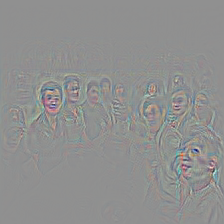

In [2]:

deconv_timer = torch.Timer()
conv5_fm = net:get(1):get(13).output
deconv5 = cudnn.SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), 27 )
conv4_fm_c5 = deconv5:forward(conv5_fm)
conv4_fm_c5 = cudnn.ReLU(true):forward(conv4_fm_c5)

deconv4 = cudnn.SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true )
conv3_fm_c5 = deconv4:forward(conv4_fm_c5)
conv3_fm_c5 = cudnn.ReLU(true):forward(conv3_fm_c5)

deconv3 = cudnn.SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true )
pool2_fm_c5 = deconv3:forward(conv3_fm_c5)

--unpool2 = cudnn.SpatialUnPooling(net:get(1):get(8), net:get(1):get(7).output )
unpool2 = unpooling_layers[2]
conv2_fm_c5 = unpool2:forward(pool2_fm_c5)
conv2_fm_c5 = cudnn.ReLU(true):forward(conv2_fm_c5)

deconv2 = cudnn.SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true )
pool1_fm_c5 = deconv2:forward(conv2_fm_c5)

--unpool1 = cudnn.SpatialUnPooling(net:get(1):get(4), net:get(1):get(3).output )
unpool1 = unpooling_layers[1]
conv1_fm_c5 = unpool1:forward(pool1_fm_c5)
conv1_fm_c5 = cudnn.ReLU(true):forward(conv1_fm_c5)

deconv1 = cudnn.SpatialDeconvolution( net:get(1):get(1), I:size(2), true )
vis_c5 = deconv1:forward(conv1_fm_c5)
print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c5)

==> Time elapsed: 0.24166107177734 seconds	


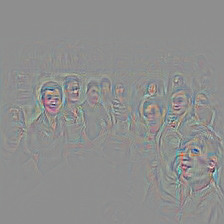

In [3]:
-- set deconvNet
deconvNet = nn.Sequential()

conv5_fm = net:get(1):get(13).output
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), 27 ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconvNet:add(unpooling_layers[2])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconvNet:add(unpooling_layers[1])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))




deconv_timer = torch.Timer()
vis_c5 = deconvNet:forward(conv5_fm)

print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c5)


==> Time elapsed: 0.19664096832275 seconds	


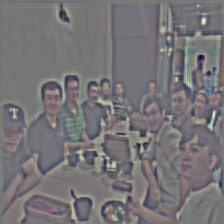

In [4]:
conv1_fm = net:get(1):get(1).output
deconv_idx = torch.IntTensor(96)
--deconv_idx[1] = 47
--deconv_idx[2] = 94

for i=1,96 do
   deconv_idx[i]=i 
end

deconv_timer = torch.Timer()
deconv1 = cudnn.SpatialDeconvolution( net:get(1):get(1), I:size(2), deconv_idx  )
vis_n = deconv1:forward(conv1_fm)

print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')

itorch.image(vis_n)


 256
  26
  26
[torch.LongStorage of size 3]



==> Time elapsed: 3.2020819187164 seconds	


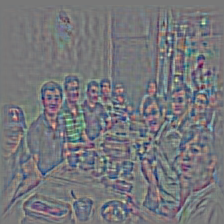

In [5]:
conv2_fm = net:get(1):get(5).output
print(conv2_fm:size() )

deconv_idx = torch.IntTensor(256)
for i=1,256 do
   deconv_idx[i]=i 
end

deconv_timer = torch.Timer()
deconv2 = nn.Sequential()
deconv2:add(cudnn.SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), deconv_idx ))
deconv2:add(unpooling_layers[1])
deconv2:add(cudnn.ReLU(true))
deconv2:add(cudnn.SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))

vis_c2 = deconv2:forward(conv2_fm)
print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')



itorch.image(vis_c2)


 384
  13
  13
[torch.LongStorage of size 3]



==> Time elapsed: 10.847911119461 seconds	


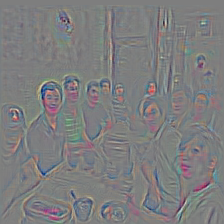

In [6]:
conv3_fm = net:get(1):get(9).output
print(conv3_fm:size() )

deconv_idx = torch.IntTensor(384)
for i=1,384 do
   deconv_idx[i]=i 
end

deconv_timer = torch.Timer()
deconv3 = nn.Sequential()

deconv3:add(cudnn.SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), deconv_idx ))
deconv3:add(unpooling_layers[2])
deconv3:add(cudnn.ReLU(true))
deconv3:add(cudnn.SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconv3:add(unpooling_layers[1])
deconv3:add(cudnn.ReLU(true))
deconv3:add(cudnn.SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))

vis_c3 = deconv3:forward(conv3_fm)
print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')




itorch.image(vis_c3)


 384
  13
  13
[torch.LongStorage of size 3]



==> Time elapsed: 16.335717916489 seconds	


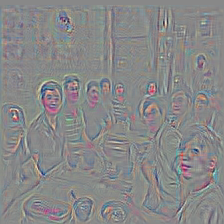

In [7]:
conv4_fm = net:get(1):get(11).output
print(conv4_fm:size() )

deconv_idx = torch.IntTensor(384)
for i=1,384 do
   deconv_idx[i]=i 
end

deconv_timer = torch.Timer()
deconv4 = nn.Sequential()

deconv4:add(cudnn.SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), deconv_idx ))
deconv4:add(cudnn.ReLU(true))
deconv4:add(cudnn.SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconv4:add(unpooling_layers[2])
deconv4:add(cudnn.ReLU(true))
deconv4:add(cudnn.SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconv4:add(unpooling_layers[1])
deconv4:add(cudnn.ReLU(true))
deconv4:add(cudnn.SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))

vis_c4 = deconv4:forward(conv4_fm)
print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')


itorch.image(vis_c4)


 256
  13
  13
[torch.LongStorage of size 3]



==> Time elapsed: 11.125161886215 seconds	


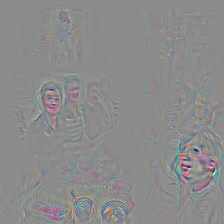

In [8]:
conv5_fm = net:get(1):get(13).output
print(conv5_fm:size() )

deconv_idx = torch.IntTensor(256)
for i=1,256 do
   deconv_idx[i]=i 
end



deconv_timer = torch.Timer()
deconvNet = nn.Sequential()

deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), deconv_idx ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconvNet:add(unpooling_layers[2])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconvNet:add(unpooling_layers[1])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))


vis_c5 = deconvNet:forward(conv5_fm)

print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c5)